In [48]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, Sequential, regularizers
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [49]:
# Paths for training, validation, and testing datasets
data_train_path = 'transform_images/train'
data_test_path = 'transform_images/test'
data_val_path = 'transform_images/validation'

In [50]:
# Image dimensions
img_width = 240
img_height = 240
batch_size = 32

In [51]:
# Data augmentation to artificially increase dataset size
data_augmentation = Sequential([
    layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2)
])

c:\Users\dkkan\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [52]:
# Load datasets
data_train = image_dataset_from_directory(
    data_train_path,
    shuffle=True,
    image_size=(img_width, img_height),
    batch_size=batch_size,
    validation_split=False
)  

Found 458 files belonging to 4 classes.


In [53]:
data_cat = data_train.class_names
data_cat

['cool_thermal_images', 'fire_img', 'hot_thermal images', 'short_ciruit_img']

In [54]:
data_val = image_dataset_from_directory(
    data_val_path,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False,
    validation_split=False
)

Found 458 files belonging to 4 classes.


In [55]:
data_test = image_dataset_from_directory(
    data_test_path,
    image_size=(img_height, img_width),
    shuffle=False,
    batch_size=batch_size,
    validation_split=False
)

Found 458 files belonging to 4 classes.


In [56]:
# Preprocessing with augmentation and normalization
AUTOTUNE = tf.data.AUTOTUNE
data_train = data_train.map(lambda x, y: (data_augmentation(x), y))
data_train = data_train.prefetch(buffer_size=AUTOTUNE)
data_val = data_val.prefetch(buffer_size=AUTOTUNE)

In [57]:
# Load a pretrained model (e.g., MobileNetV2)
base_model = tf.keras.applications.MobileNetV2(input_shape=(img_height, img_width, 3),
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False  # Freeze the base model

C:\Users\dkkan\AppData\Local\Temp\ipykernel_12820\1995106350.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(input_shape=(img_height, img_width, 3),


In [58]:
# Build the model
model = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(data_cat), activation='softmax')
])

In [59]:
# Compile the model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

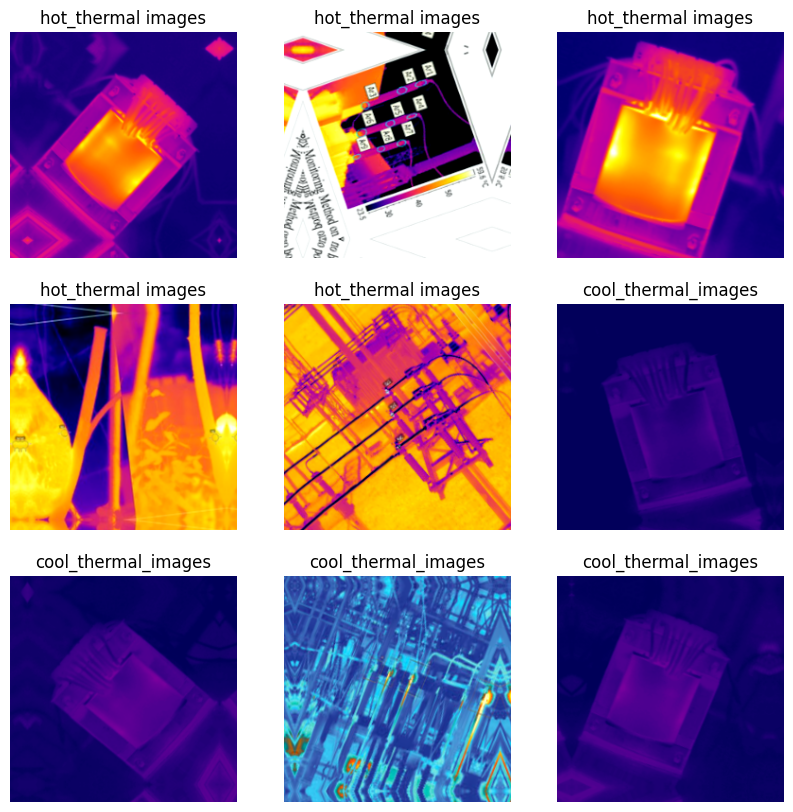

In [60]:
plt.figure(figsize=(10,10))
for image, labels in data_train.take(1):
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.imshow(image[i].numpy().astype('uint8'))
        plt.title(data_cat[labels[i]])
        plt.axis('off')

In [61]:
# Callbacks for early stopping and learning rate adjustment
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3)

In [62]:
# Train the model
epochs_size = 25  # Increase number of epochs for better performance
history = model.fit(data_train, validation_data=data_val, epochs=epochs_size, callbacks=[early_stopping, lr_scheduler])

Epoch 1/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.5609 - loss: 1.4359 - val_accuracy: 0.8013 - val_loss: 0.5088 - learning_rate: 0.0010
Epoch 2/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 52s 3s/step - accuracy: 0.7996 - loss: 0.5963 - val_accuracy: 0.8690 - val_loss: 0.3725 - learning_rate: 0.0010
Epoch 3/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 86s 3s/step - accuracy: 0.8370 - loss: 0.4586 - val_accuracy: 0.8799 - val_loss: 0.3112 - learning_rate: 0.0010
Epoch 4/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 15s 910ms/step - accuracy: 0.8239 - loss: 0.4356 - val_accuracy: 0.8865 - val_loss: 0.2876 - learning_rate: 0.0010
Epoch 5/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 723ms/step - accuracy: 0.8483 - loss: 0.3908 - val_accuracy: 0.9236 - val_loss: 0.2431 - learning_rate: 0.0010
Epoch 6/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 736ms/step - accuracy: 0.8655 - loss: 0.3526 - val_accuracy: 0.9367 - val_loss: 0.2145 - learning_rate: 0.0010
Epoch 7/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 703ms/step - accuracy: 0.9115 - loss: 0.2329 - va

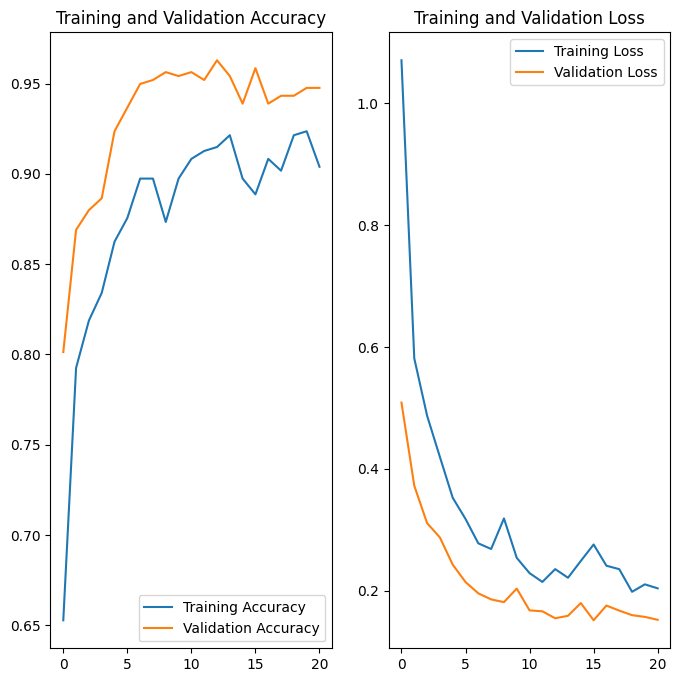

In [65]:
# Plot accuracy and loss curves
epochs_range = range(len(history.history['accuracy']))
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(epochs_range, history.history['accuracy'], label='Training Accuracy')
plt.plot(epochs_range, history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(epochs_range, history.history['loss'], label='Training Loss')
plt.plot(epochs_range, history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

ValueError: x and y must have same first dimension, but have shapes (25,) and (21,)

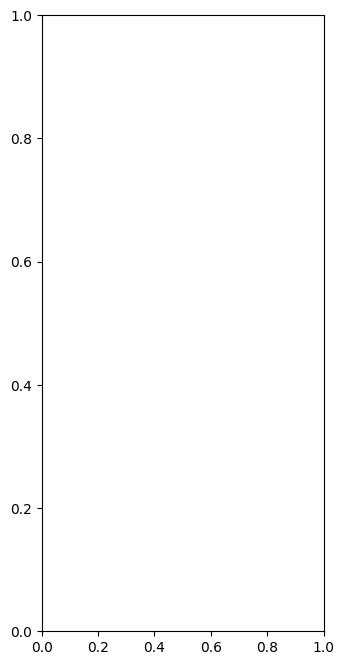

In [67]:
epochs_range = range(epochs_size)
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(epochs_range,history.history['accuracy'],label = 'Training Accuracy')
plt.plot(epochs_range, history.history['val_accuracy'],label = 'Validation Accuracy')
plt.title('Accuracy')

plt.subplot(1,2,2)
plt.plot(epochs_range,history.history['loss'],label = 'Training Loss')
plt.plot(epochs_range, history.history['val_loss'],label = 'Validation Loss')
plt.title('Loss')

In [68]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)         │ (None, 240, 240, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 8, 8, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,751,438 (10.50 MB)

 Trainable params: 164,484 (642.52 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

 Optimizer params: 328,970 (1.25 MB)

In [70]:
image = 'p5052.bmp'
image = tf.keras.utils.load_img(image, target_size=(img_height,img_width))
img_arr = tf.keras.utils.array_to_img(image)
img_bat=tf.expand_dims(img_arr,0)

predict = model.predict(img_bat)

score = tf.nn.softmax(predict)

print('Transformer in image is {} with accuracy of {:0.2f}'.format(data_cat[np.argmax(score)],np.max(score)*100))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Transformer in image is cool_thermal_images with accuracy of 40.05
